In [5]:
%load_ext autoreload
%autoreload 2
import sys, os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader

from load_model_from_ckpt import load_model, get_readout_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

from os.path import expanduser
home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Download experiment (model checkpoint, config, etc.)

# Load model checkpoint

In [228]:
model_path = '/ccn2/u/thekej/ucf10132_big192_288_4c4_unetm_spade/logs/'
ckpt_path = glob.glob(os.path.join(model_path, "checkpoint_*.pt"))[0]
    
# load model
scorenet, config = load_model(ckpt_path, device)
# get sampler
sampler = get_readout_sampler(config)

In [229]:
print(device)
print(ckpt_path)
print(config)

cuda
/ccn2/u/thekej/ucf10132_big192_288_4c4_unetm_spade/logs/checkpoint_550000.pt
Namespace(data=Namespace(channels=3, color_jitter=0.0, dataset='UCF101', gaussian_dequantization=False, image_size=64, logit_transform=False, num_frames=4, num_frames_cond=4, num_workers=4, prob_mask_cond=0.0, random_flip=True, rescaled=True, uniform_dequantization=False), device=device(type='cuda'), fast_fid=Namespace(batch_size=1000, begin_ckpt=5000, end_ckpt=300000, ensemble=False, freq=5000, n_steps_each=0, num_samples=1000, pr_nn_k=3, step_lr=0.0, verbose=False), model=Namespace(arch='unetmore', attn_resolutions=[8, 16, 32], ch_mult=[1, 2, 3, 4], cond_emb=False, conditional=True, depth='deeper', dropout=0.1, ema=True, ema_rate=0.999, gamma=False, gff=False, n_head_channels=288, ngf=288, noise_in_cond=False, nonlinearity='swish', normalization='InstanceNorm++', num_classes=1000, num_res_blocks=2, output_all_frames=False, sigma_begin=0.02, sigma_dist='linear', sigma_end=0.0001, spade=True, spade_dim=19

# Load data

In [230]:
from datasets.physion import PhysionDataset

In [231]:
def get_dataset(config):
    
    frames_per_sample = 48
    dataset = PhysionDataset('/ccn2/u/thekej/phys_readouts_mcvd_all/shard_0001.hdf5', 
                             frames_per_sample=frames_per_sample, 
                             image_size=config.data.image_size, train=False, random_time=True,
                             random_horizontal_flip=False,
                             complete=True,
                             simulation=False) #change this

    return dataset

In [288]:
def inverse_transform(config, X):
    X = X.to('cpu')
    if hasattr(config, 'image_mean'):
        X = X + config.image_mean.to(X.device)[None, ...]

    if config.data.logit_transform:
        X = torch.sigmoid(X)
    elif config.data.rescaled:
        X = (X + 1.) / 2.
    return torch.clamp(X, 0.0, 1.0)

In [289]:
dataset = get_dataset(config)

Checking shard_lengths in ['/ccn2/u/thekej/phys_readouts_mcvd_all/shard_0001.hdf5']
h5: Opening /ccn2/u/thekej/phys_readouts_mcvd_all/shard_0001.hdf5... h5: paths 1 ; shard_lengths [9993] ; total 9993
Dataset length: 9993


In [348]:
# dataloader = DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True,
#                         num_workers=config.data.num_workers)
# train_iter = iter(dataloader)
# x, y = next(train_iter)

test_loader = DataLoader(dataset, batch_size=1, shuffle=False,#config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)

torch.Size([1, 48, 3, 64, 64])


In [349]:
test_x = data_transform(config, test_x)
#print(test_x * 255)
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([1, 12, 64, 64]) torch.Size([1, 12, 64, 64])


# Load initial samples

In [350]:
init = init_samples(len(real), config)

torch.Size([1, 12, 64, 64]) torch.Size([12, 64, 64])


,,,,,,,,,,,

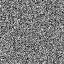
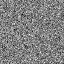
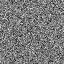
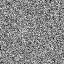
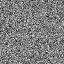
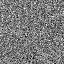
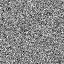
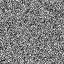
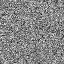
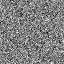
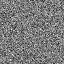
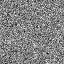

In [351]:
i = 0
print(init.shape, init[i].shape)
media.show_images(init[i])

# Predict

,,,

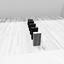
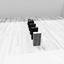
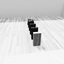
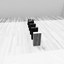

,,,

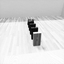
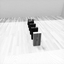
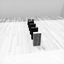
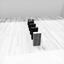

,,,

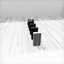
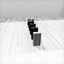
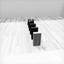
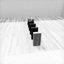

,,,

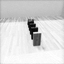
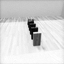
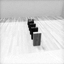
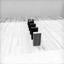

,,,

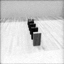
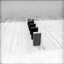
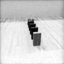
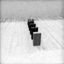

,,,

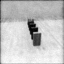
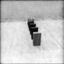
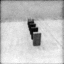
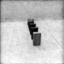

,,,

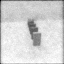
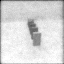
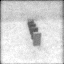
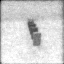

,,,

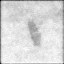
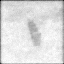
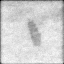
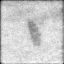

,,,

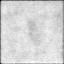
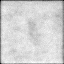
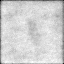
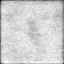

,,,

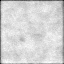
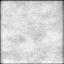
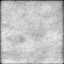
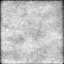

In [352]:
preds = []
for i in range(10):
    init = init_samples(len(real), config)
    pred, gamma, beta, mid = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=False)
    #show_video(pred[0], config)
    media.show_images(pred[0][::3])
    cond = pred#inverse_transform(config, pred)

In [323]:
#pred = inverse_transform(config, pred[i])
#print(pred[i].shape)
def show_video(frames, config):
    #pred = inverse_transform(config, frames)
    print(pred.shape)
    media.show_images(pred)

torch.Size([1, 12, 64, 64])


,,,

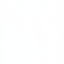
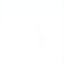
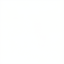
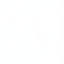

In [195]:
print(preds[0].shape)
show_video(preds[0], config)

,,,

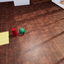
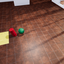
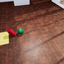
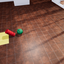

In [138]:
show_video(cond[30], config)

In [190]:
p = torch.stack(preds)
print(preds[0].shape)
p.shape

torch.Size([4, 3, 64, 64])


torch.Size([5, 4, 3, 64, 64])

,,,

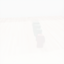
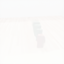
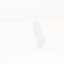
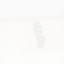

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


,,,

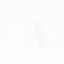
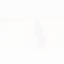
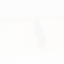
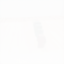

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


,,,

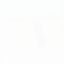
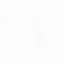
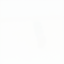
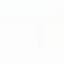

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


,,,

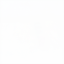
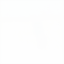
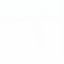
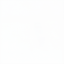

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [191]:
import imageio
import numpy as np


for i in range(4):
    # Create a list of image frames from the array
    frames = inverse_transform(config, p[i])
    media.show_images(frames.permute(0, 2, 3, 1))
    frames = frames.numpy().transpose(0, 2, 3, 1)

    # Save the frames as a GIF
    imageio.mimsave('%d.gif'%i, frames)
